In [1]:
!bash /home/azureuser/cloudfiles/code/blobfuse/blobfuse_raadsinformatie.sh

In [2]:
import sys
sys.path.append("..")

# Select where to run notebook: "azure" or "local"
my_run = "azure"

# import my_secrets as sc
# import settings as st

if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf


import os
if my_run == "azure":
    if not os.path.exists(cf.HUGGING_CACHE):
        os.mkdir(cf.HUGGING_CACHE)
    os.environ["TRANSFORMERS_CACHE"] = cf.HUGGING_CACHE


import pandas as pd

# set-up environment - GEITje-7b-chat InContextLearning:
# - install blobfuse -> sudo apt-get install blobfuse
# - pip install transformers
# - pip install torch
# - pip install accelerate
# - pip install jupyter
# - pip install ipywidgets

## Notebook Overview
Goal: gain insight into predictions of finetuning experiment

In [3]:
txt = pd.read_pickle(f"{cf.output_path}/txtfiles.pkl")

In [4]:
from transformers import AutoTokenizer
from collections import Counter
from sklearn.metrics import classification_report
import sys
sys.path.append('../src/') 
import prompt_template as pt
import warnings
warnings.simplefilter('ignore')


import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


def get_tokens(model_name, df, text_col, new_col_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    all_texts = list(df[text_col].values)

    all_tokens = []
    all_tokens_len = []
    for txt in all_texts:
        tokens = tokenizer.tokenize(txt)
        all_tokens.append(tokens)
        all_tokens_len.append(len(tokens))

    df[new_col_name] = all_tokens
    df[f"count_{new_col_name}"] = all_tokens_len
    return df

def format_label(label):
    format = f"""{{'categorie': {label}}}"""
    return format
    

def get_response_length(df, model_name):
    # convert response column into tokens, using models tokenizer (so either geitje, mistral or Llama)
    df = get_tokens(model_name, df, 'response', 'responseTokens')

    # convert label into ideal format
    df['label_formatted'] = df['label'].apply(format_label)
    # convert ideal format into tokens, so that we know the ideal length of the responses
    df_ideal = get_tokens(model_name, df.loc[df['run_id']==df.iloc[0]['run_id']], 'label_formatted', 'label_formattedTokens')

    # for each run, describe the response lengths
    description = df.groupby('run_id')['count_responseTokens'].describe()
    description.loc[len(description)] = df_ideal['count_label_formattedTokens'].describe()
    
    print("RESPONSE LENGTH")
    description = description.rename(index={description.index[-1]: 'IDEAL'}).round(1)
    display(description)
    return df
   

def prediction_errors(df):
    print('PREDICTION ERRORS')
    run_ids = sorted(list(set(df['run_id'])))

    error_names = ['NoPredictionInOutput', 'MultiplePredictionErrorInFormatting','NoPredictionFormat', 'MultiplePredictionErrorInOutput']

    # only select row that have prediction error -> response of which a prediction could not be extracted. 
    errors_df = df.loc[df['prediction'].isin(error_names)]

    df_errors_count = pd.DataFrame(columns=error_names)

    for runid in run_ids:
        subdf = errors_df.loc[errors_df['run_id']==runid]
        # count for each error the instances
        count = dict(Counter(subdf['prediction']))

        # check if all errors are included, else set that error to 0
        for error in error_names:
            if error not in count.keys():
                count[error]=0

        df_errors_count.loc[len(df_errors_count)] = count

    df_errors_count.index = run_ids
    df_errors_count['total'] = df_errors_count.sum(axis=1)

    print("Count of prediction errors for each run:")
    display(df_errors_count)

    df_classes_in_response_count = pd.DataFrame(columns=['responses with 0 classes', 'responses with 1 classes', 'responses with 2 classes', 'Correct label in response'])

    for run_id in run_ids:
        subdf = errors_df.loc[errors_df['run_id']==run_id]

        classes_in_responses = []
        correct_class_in_response = []
        for index, row in subdf.iterrows():
            # for each response, return list with all labels that are named in response
            classes_in_response = [category.lower() for category in pt.get_class_list() if category.lower() in row['response'].lower()]
            classes_in_responses.append(classes_in_response)

            # for each response, check if true label is named in response.
            if row['label'].lower() in classes_in_response:
                correct_class_in_response.append(True)
            else:
                correct_class_in_response.append(False)

        # count how many classes are named in a response
        amount_of_classes = dict(Counter([len(response) for response in classes_in_responses]))
        amount_of_classes = {f"responses with {k} classes":v for k,v in amount_of_classes.items()}
        amount_of_classes['Correct label in response'] = f"{correct_class_in_response.count(True)} out of {len(subdf)} prediction errors ({round(correct_class_in_response.count(True)/ len(subdf)*100,1)}%)" 
        df_classes_in_response_count.loc[len(df_classes_in_response_count)] = amount_of_classes

        
    df_classes_in_response_count.index = run_ids

    print('amount of class in responses:')
    display(df_classes_in_response_count)

    # for each run count the errors per class
    count_error_class_df_list = []
    for run_id in run_ids:
        # select errors for current runid
        subdf = errors_df.loc[errors_df['run_id']==run_id]
        errors_count_per_class = dict()
        # for each class count the errors
        for category in pt.get_class_list():
            class_df = subdf.loc[subdf['label']==category.lower()]
            count_errors = dict(Counter(class_df['prediction']))
            # sort the errors from highest to lowest for each class
            count_errors = dict(sorted(count_errors.items(), key=lambda item: item[1], reverse=True))
            errors_count_per_class[category] = count_errors

        # create df
        df_errors_count = pd.DataFrame(list(errors_count_per_class.items()), columns=['Class', run_id])
        # add df to list with the dfs of other runs
        count_error_class_df_list.append(df_errors_count)
    
    # combine df into one
    df_errors_count = count_error_class_df_list[0]
    for count_df in count_error_class_df_list[1:]:
        df_errors_count = df_errors_count.merge(count_df, on='Class', how='outer')
    
    pd.set_option('display.max_colwidth', None)
    print('Amount of errors type per class per run:')
    display(df_errors_count)



def evaluation_metrics(df):
    warnings.filterwarnings("ignore", category=UserWarning)
    report = classification_report(df['label'], df['prediction'])
    print('EVALUATION METRICS')
    print(report)


def percentage_mistakes(count):
    return f"{round(count/1100*100,1)}%"

def mistakes(df, detailed=False):
    print('MISTAKES. INCLUDES PREDICTIONS ERRORS.')
    run_ids = sorted(list(set(df['run_id'])))

    # select all response where the prediction was not correct
    mistakes = df.loc[df['label'] != df['prediction']]

    # groupby run_id so we get the amount of mistakes per run
    mistakes_per_run = mistakes.groupby('run_id').size().reset_index(name='count')
    mistakes_per_run['percentage of total predictions'] = mistakes_per_run['count'].apply(percentage_mistakes)
    print("Total amount of mistakes per run:")
    display(mistakes_per_run)

    # for each run get the amount of mistakes per class
    df_count_class = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])
    for run_id in run_ids:
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes per class
        class_count = dict(Counter(subdf['label']))

        # if a class is not included in mistakes, set counter to 0
        for category in pt.get_class_list():
            if category.lower() not in class_count.keys():
                class_count[category.lower()] = 0

        # add count of class to df
        df_count_class.loc[len(df_count_class)] = class_count

    # reset index to runids
    df_count_class.index = run_ids
    print("Amount of mistakes per class for each run:")
    display(df_count_class)

    # For each run get for each class the highest mistakes
    df_highest_class = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])
    for run_id in run_ids:
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes of runid
        count_mistakes_per_class = dict(Counter(subdf['label']))

        class_count = subdf.groupby('label')['prediction'].value_counts().reset_index(name='count')
        highest_per_class = dict()
        for label in set(class_count['label']):
            # for each class select the class for which it made the most mistakes
            highest_count_row = class_count.iloc[class_count[class_count['label'] == label]['count'].idxmax()]
            highest_per_class[label] = f"{highest_count_row['prediction']} ({highest_count_row['count']} out of {count_mistakes_per_class[label]})"

        # add to df
        df_highest_class.loc[len(df_highest_class)] = highest_per_class
    # reset index to run_id
    df_highest_class.index = run_ids
    print("Highest mistakes per class for each run:")
    display(df_highest_class.transpose())
   

def runtime(df):
    print("RUNTIME")

    # select all docs that have runtime longer than 75th percentile.
    percentile_75 = df['runtime'].quantile(0.75)

    # count how many docs for each class take longer than 75th percentile
    df_count_long_runtimes = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])

    # calculate average runtime per doc for each class
    df_average_runtime = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])

    # for each run_id, calculate average runtime and count how many docs exceed 75th percentile
    for run_id in set(df['run_id']):
        subdf = df.loc[df['run_id']==run_id]

        # get very long runtimes
        percentile_75 = subdf['runtime'].quantile(0.75)
        above_75th_percentile = subdf[subdf['runtime'] > percentile_75]
        count_long_runtimes_per_class = dict(Counter(above_75th_percentile['label']))
        df_count_long_runtimes.loc[len(df_count_long_runtimes)] = count_long_runtimes_per_class

        # average runtime per class
        average_runtime_per_class = subdf.groupby('label')['runtime'].mean()
        df_average_runtime.loc[len(df_average_runtime)] = average_runtime_per_class

    df_count_long_runtimes.index = list(set(df['run_id']))
    df_average_runtime.index = list(set(df['run_id']))

    print('Description of runtime per doc:')
    display(df.groupby('run_id')['runtime'].describe().round(1))

    print(f"Amount of docs that took longer than 75th percentile per class:")
    display(df_count_long_runtimes)

    print('Average runtime per doc for each class')
    display(df_average_runtime.transpose().sort_values(by=list(set(df['run_id']))).round(1))


def plot_confusion_matrix(df):
    run_ids = sorted(df['run_id'].unique())

    # Number of plots per row
    plots_per_row = 2

    # Calculate the number of rows needed
    n_rows = (len(run_ids) + plots_per_row - 1) // plots_per_row

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(14, 7 * n_rows))

    # Flatten the axes array if there are multiple rows
    if n_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, run_id in enumerate(run_ids):
        subdf = df[df['run_id'] == run_id]
        class_labels = sorted(set(subdf['prediction']).union(set(subdf['label'])))
        class_dict = {label: idx for idx, label in enumerate(class_labels)}

        y_true = np.array([class_dict[label] for label in subdf['label']])
        y_pred = np.array([class_dict[label] for label in subdf['prediction']])

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_labels)))

        # Plot confusion matrix
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_labels, yticklabels=class_labels, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix for RUN_ID: {run_id}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


/anaconda/envs/2AmsterdamLLM/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [7]:
# truncation experiment
predictions =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/zeroshot_prompt_geitje/First200Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/zeroshot_prompt_mistral_llama/First200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/zeroshot_prompt_mistral_llama/First200Last0Predictions.pkl")
epoch0 = pd.concat([predictions, predictions2, predictions3])

predictions =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/1epochs/GEITjeFirst200Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/1epochs/LlamaFirst200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/1epochs/MistralFirst200Last0Predictions.pkl")
epoch1 = pd.concat([predictions, predictions2, predictions3])

predictions =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/2epochs/GEITjeFirst200Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/2epochs/LlamaFirst200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/2epochs/MistralFirst200Last0Predictions.pkl")
epoch2 = pd.concat([predictions, predictions2, predictions3])

predictions =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/3epochs/GEITjeFirst200Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/3epochs/LlamaFirst200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/finetuning/3epochs/MistralFirst200Last0Predictions.pkl")
epoch3 = pd.concat([predictions, predictions2, predictions3])

combined = pd.concat([epoch0, epoch1, epoch2, epoch3])
combined = pd.concat([epoch1, epoch2, epoch3])

### Confusion Matrix

In [8]:
from sklearn.metrics import classification_report

def cf_ma(df):
    run_ids = sorted(list(set(df['run_id'])))
    error_names = ['NoPredictionInOutput', 'MultiplePredictionErrorInFormatting','NoPredictionFormat', 'MultiplePredictionErrorInOutput']

    for run_id in run_ids:
        print(run_id)
        subdf = df.loc[df['run_id']==run_id]
        print(len(subdf.loc[subdf['prediction'].isin(error_names)]))
        subdf.loc[subdf['prediction'].isin(error_names),'prediction'] = 'PredictionError'

        y_pred = subdf['prediction']
        y_true = subdf['label']
        print(classification_report(y_true, y_pred))

cf_ma(combined)

FT_AmsterdamDocClassificationGEITje200T1Epochszeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0
0
                     precision    recall  f1-score   support

        actualiteit       0.93      0.83      0.88       100
             agenda       0.99      0.98      0.98       100
            besluit       0.97      0.96      0.96       100
              brief       0.99      0.92      0.95       100
          factsheet       1.00      0.25      0.40       100
              motie       0.89      0.99      0.94       100
  onderzoeksrapport       0.55      1.00      0.71       100
         raadsadres       0.89      0.98      0.93       100
       raadsnotulen       1.00      0.97      0.98       100
schriftelijke vraag       1.00      0.93      0.96       100
         voordracht       0.97      0.99      0.98       100

           accuracy                           0.89      1100
          macro avg       0.93      0.89      0.88      1100
       weighted avg       0.93      0.89 

### Response Length

In [ ]:
description = get_response_length(combined, 'meta-llama/Llama-2-7b-chat-hf')

RESPONSE LENGTH


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
FT_AmsterdamDocClassificationGEITje200T1Epochszeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,1100.0,9.6,1.4,8.0,8.0,9.0,10.2,12.0
FT_AmsterdamDocClassificationGEITje200T2Epochszeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,1100.0,9.5,1.4,8.0,8.0,9.0,10.0,12.0
FT_AmsterdamDocClassificationGEITje200T3Epochszeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,1100.0,9.5,1.4,8.0,8.0,9.0,10.0,12.0
FT_AmsterdamDocClassificationLlama200T1Epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,10.5,1.4,9.0,9.0,10.0,11.2,14.0
FT_AmsterdamDocClassificationLlama200T2Epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,10.6,1.4,9.0,9.0,10.0,12.0,13.0
FT_AmsterdamDocClassificationLlama200T3Epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,10.6,1.4,9.0,9.0,10.0,12.0,13.0
FT_AmsterdamDocClassificationMistral200T1Epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,9.5,1.4,8.0,8.0,9.0,10.0,12.0
FT_MistralTry2epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,9.6,1.5,8.0,8.0,9.0,10.0,15.0
FT_MistralTry3epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,9.5,1.4,8.0,8.0,9.0,10.0,15.0


### Errors

In [7]:
prediction_errors(combined)

PREDICTION ERRORS
Count of prediction errors for each run:


,NoPredictionInOutput,MultiplePredictionErrorInFormatting,NoPredictionFormat,MultiplePredictionErrorInOutput,total
FT_AmsterdamDocClassificationGEITje200T1Epochszeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,0,0,0,0,0
FT_AmsterdamDocClassificationGEITje200T2Epochszeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,0,0,0,0,0
FT_AmsterdamDocClassificationGEITje200T3Epochszeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,0,0,0,0,0
FT_AmsterdamDocClassificationLlama200T1Epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1,0,0,0,1
FT_AmsterdamDocClassificationLlama200T2Epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1,0,0,0,1
FT_AmsterdamDocClassificationLlama200T3Epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1,0,0,0,1
FT_AmsterdamDocClassificationMistral200T1Epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,0,0,0,0,0
FT_MistralTry2epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,0,0,0,0,0
FT_MistralTry3epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,0,0,0,0,0
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,18,0,62,3,83


ZeroDivisionError: division by zero

Bad pipe message: %s [b'\x94b\xa2s\x92\xce\xc6\xb9\x94\x07\xcav\xa5\x9e\xb3', b'\xd4 \xf9IAO\x9f\xd1\xa6\xc9\xe4\x87K?\t\x1e\x87\x9d>\x9bTn\x9b\x7f^\x04\xb8K\x02\xfbrc\x8f\n\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0', b'.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04']
Bad pipe message: %s [b'\x03\x06', b'\x07\x08']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b"\xb8\xcb\x104\xd5G^y\xc8\xc1\xd2j[\x1ad*\xb5\xb4\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11

In [8]:
yeet = pd.read_pickle(f"{cf.output_path}/finetuning_output/overview_models.pkl")

In [12]:
display(yeet.loc[yeet['model']=='FemkeBakker/MistralTry3epochs'])

,model,base_model,chat_dataset,train_set,test_set,training_args,resume_from_checkpoint,date,runtime,Error,run_id,save_to_hub,output_dir,num_train_epochs
0,FemkeBakker/MistralTry3epochs,mistralai/Mistral-7B-Instruct-v0.2,FemkeBakker/AmsterdamBalancedFirst200Tokens,train,val,"TrainingArguments(\n_n_gpu=1,\naccelerator_con...",True,2024-06-14 12:26:24.665959+02:00,2984.912049,False,32,True,/home/azureuser/cloudfiles/code/blobfuse/raads...,3.0


In [11]:
display(epoch3.loc[(epoch3['run_id']=='FT_AmsterdamDocClassificationMistral200T3Epochszeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0') & (epoch3['prediction']=='NoPredictionFormat')])

,id,path,text_column,prompt_function,response,prediction,label,runtime,date,prompt,run_id,shots,new_prediction,Original_Prediction,matches_complete_regex,matches_adjusted_regex
0,22658,/home/azureuser/cloudfiles/code/blobfuse/raads...,TruncationLlamaTokensFront200Back0,zeroshot_prompt_mistral_llama,'Brief': Brief},NoPredictionFormat,brief,18.722284,2024-06-04 22:01:20.897529+02:00,Classificeer het document in één van de catego...,FT_AmsterdamDocClassificationMistral200T3Epoch...,0,NoPredictionFormat,NoPredictionFormat,0.0,0.0
5,14070,/home/azureuser/cloudfiles/code/blobfuse/raads...,TruncationLlamaTokensFront200Back0,zeroshot_prompt_mistral_llama,'Agenda': Agenda},NoPredictionFormat,agenda,19.226218,2024-06-04 22:08:27.425967+02:00,Classificeer het document in één van de catego...,FT_AmsterdamDocClassificationMistral200T3Epoch...,0,NoPredictionFormat,NoPredictionFormat,0.0,0.0
5,22798,/home/azureuser/cloudfiles/code/blobfuse/raads...,TruncationLlamaTokensFront200Back0,zeroshot_prompt_mistral_llama,' categorie': Brief,NoPredictionFormat,brief,16.956013,2024-06-04 22:20:06.126946+02:00,Classificeer het document in één van de catego...,FT_AmsterdamDocClassificationMistral200T3Epoch...,0,NoPredictionFormat,NoPredictionFormat,0.0,0.0
6,21526,/home/azureuser/cloudfiles/code/blobfuse/raads...,TruncationLlamaTokensFront200Back0,zeroshot_prompt_mistral_llama,"'Brief': Actualiteit, factsheet, Schriftelijke...",NoPredictionFormat,brief,383.040715,2024-06-04 22:26:29.169489+02:00,Classificeer het document in één van de catego...,FT_AmsterdamDocClassificationMistral200T3Epoch...,0,NoPredictionFormat,NoPredictionFormat,0.0,0.0
4,21654,/home/azureuser/cloudfiles/code/blobfuse/raads...,TruncationLlamaTokensFront200Back0,zeroshot_prompt_mistral_llama,'categorie': Brief,NoPredictionFormat,brief,18.332510,2024-06-04 22:45:05.423405+02:00,Classificeer het document in één van de catego...,FT_AmsterdamDocClassificationMistral200T3Epoch...,0,NoPredictionFormat,NoPredictionFormat,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,21524,/home/azureuser/cloudfiles/code/blobfuse/raads...,TruncationLlamaTokensFront200Back0,zeroshot_prompt_mistral_llama,'Brief': Brief},NoPredictionFormat,brief,17.879808,2024-06-05 06:30:56.461823+02:00,Classificeer het document in één van de catego...,FT_AmsterdamDocClassificationMistral200T3Epoch...,0,NoPredictionFormat,NoPredictionFormat,0.0,0.0
6,21311,/home/azureuser/cloudfiles/code/blobfuse/raads...,TruncationLlamaTokensFront200Back0,zeroshot_prompt_mistral_llama,INST: Classificeer het document in één van de ...,NoPredictionFormat,besluit,384.085826,2024-06-05 06:38:02.918371+02:00,Classificeer het document in één van de catego...,FT_AmsterdamDocClassificationMistral200T3Epoch...,0,NoPredictionFormat,NoPredictionFormat,0.0,0.0
0,20775,/home/azureuser/cloudfiles/code/blobfuse/raads...,TruncationLlamaTokensFront200Back0,zeroshot_prompt_mistral_llama,'decos': Besluit},NoPredictionFormat,besluit,19.797632,2024-06-05 06:39:36.401877+02:00,Classificeer het document in één van de catego...,FT_AmsterdamDocClassificationMistral200T3Epoch...,0,NoPredictionFormat,NoPredictionFormat,0.0,0.0
1,2898,/home/azureuser/cloudfiles/code/blobfuse/raads...,TruncationLlamaTokensFront200Back0,zeroshot_prompt_mistral_llama,'categorie': Motie,NoPredictionFormat,motie,17.905762,2024-06-05 06:39:54.308760+02:00,Classificeer het document in één van de catego...,FT_AmsterdamDocClassificationMistral200T3Epoch...,0,NoPredictionFormat,NoPredictionFormat,0.0,0.0


### Confusion Matrix

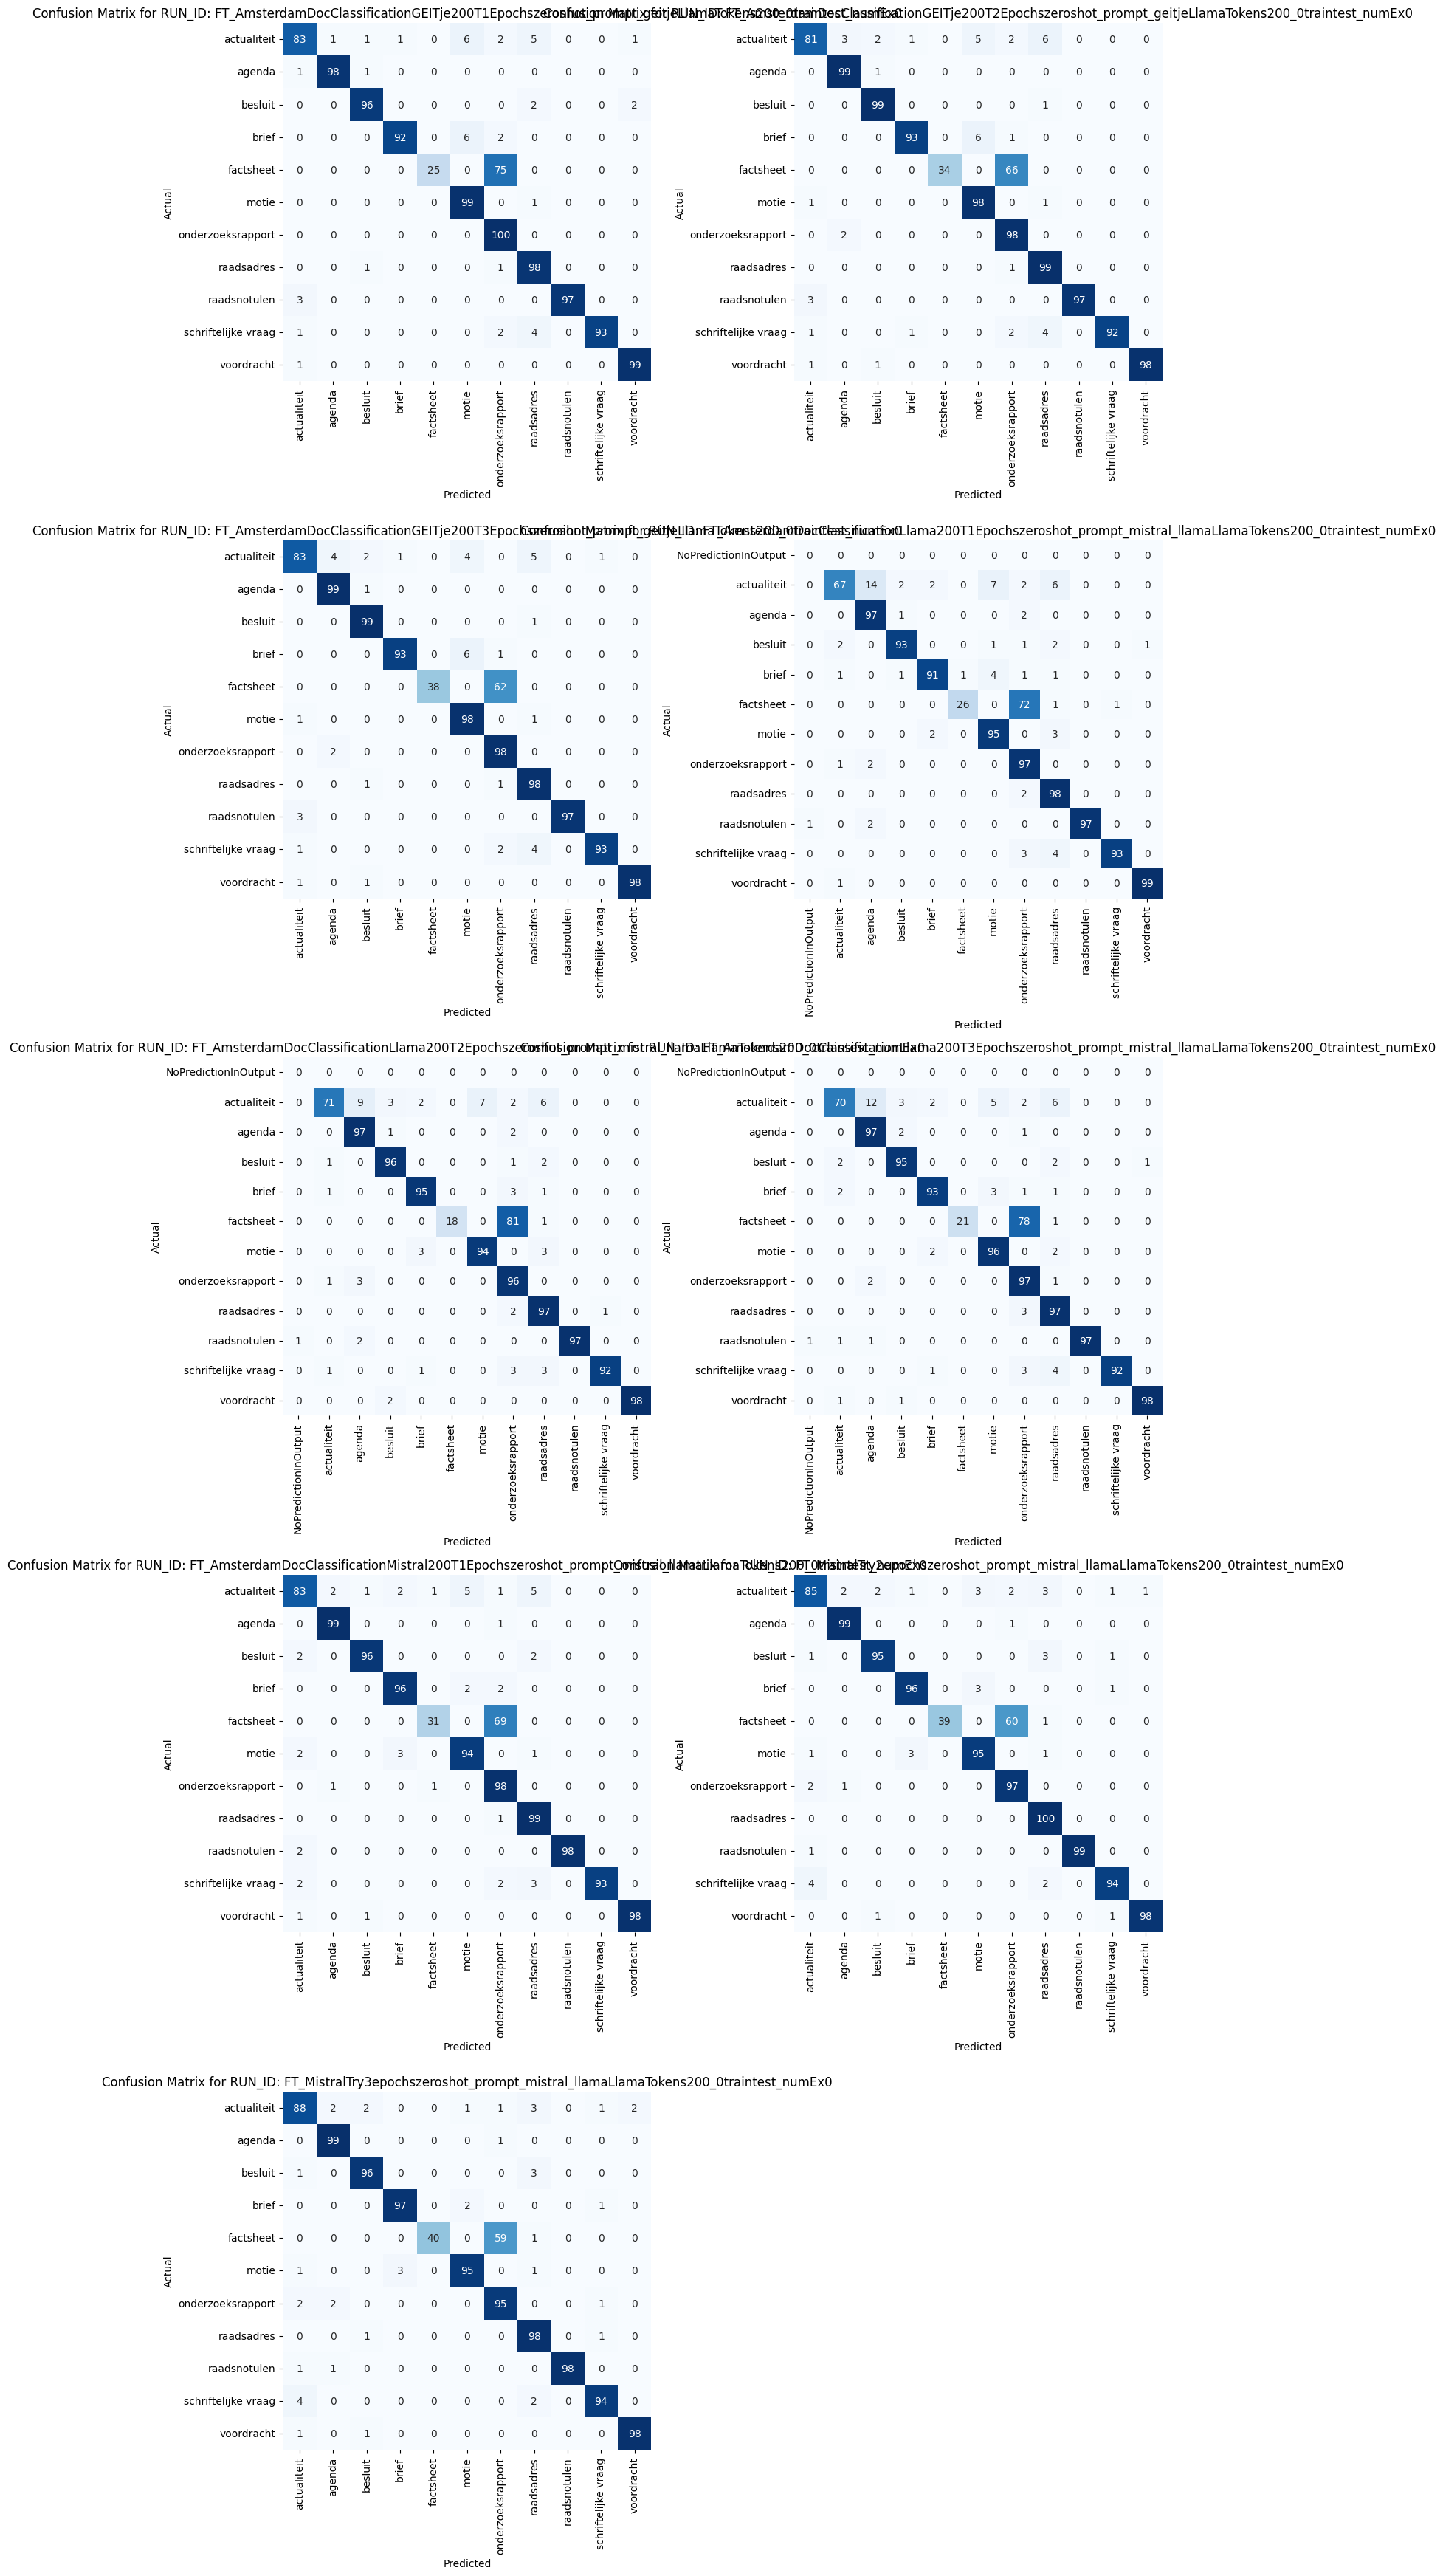

In [6]:
plot_confusion_matrix(combined)